In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
import math
from torch.utils.data import Dataset

In [112]:
class CharDataset(Dataset):

    def __init__(self, data, block_size, extractAtt=False):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
        self.attributes = extractAtt
        
        if self.attributes:
            self.dataList = self.data.split('\n') #TODO: remove later?

            self.blockIdx = []
            summation = 0
            for d in self.dataList:
                s = summation
                e = s + len(d)
                self.blockIdx.append((s,e))
                summation = e+1
    
    def __len__(self):
        if self.attributes:
            return len(self.dataList) - 1
        else:
            return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        #chunk = self.data[idx:idx + self.block_size + 1]
        chunk = self.data[self.blockIdx[idx][0]:self.blockIdx[idx][1]]
        
        # extracts other attributes
        points = None
        if self.attributes:
            dic = json.loads(chunk)
            points = []
            for xy in zip(dic['X'], dic['Y']):
                x = xy[0]
                y = xy[1]
                x.extend([y])
                x = torch.tensor(x)
                points.append(x)
            chunk = '"'+dic['EQ']+'"'
        
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        
        return x, y, points

In [113]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            text += lines #json.loads(line)                
    return text

In [114]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TrainDatasetFixed\*.json'
files = glob.glob(path)
text = processDataFiles([files[0]])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


In [115]:
# avgBlockSize = 0
# upNum = 100
# for i in tqdm(range(0,upNum)):
#     avgBlockSize += len(text.split('\n')[i])
# avgBlockSize /= upNum
# print('avg block size is {}'.format(avgBlockSize))

In [116]:
block_size = 500 # spatial extent of the model for its context

In [117]:
train_dataset = CharDataset(text, block_size, extractAtt=True) # one line of poem is roughly 50 characters

data has 243072217 characters, 43 unique.


In [118]:
sample = train_dataset.__getitem__(0)
print('X:{}\ny:{}\nPoints:{}'.format(sample[0], sample[1], sample[2]))

X:tensor([ 2,  8, 38, 31, 34,  3, 12,  9, 12,  5, 40, 12,  6, 11,  9, 17, 15,  4])
y:tensor([ 8, 38, 31, 34,  3, 12,  9, 12,  5, 40, 12,  6, 11,  9, 17, 15,  4,  2])
Points:[tensor([ 0.8300, -1.0000]), tensor([ 0.9300, -1.0000]), tensor([ 0.7200, -0.9900]), tensor([ 1.0300, -0.9800]), tensor([ 0.6200, -0.9700]), tensor([ 1.1400, -0.9500]), tensor([ 0.5200, -0.9400]), tensor([ 1.2400, -0.9100]), tensor([ 0.4100, -0.8900]), tensor([ 1.3400, -0.8600]), tensor([ 0.3100, -0.8300]), tensor([ 1.4500, -0.7900]), tensor([ 0.2100, -0.7700]), tensor([ 1.5500, -0.7200]), tensor([ 0.1000, -0.6800]), tensor([ 1.6600, -0.6300]), tensor([ 0.0000, -0.6000]), tensor([ 1.7600, -0.5400]), tensor([ 1.8600, -0.4400]), tensor([ 1.9700, -0.3300]), tensor([ 2.0700, -0.2300]), tensor([ 2.1700, -0.1200]), tensor([2.2800, 0.0000]), tensor([2.3800, 0.1100]), tensor([2.4800, 0.2200]), tensor([2.5900, 0.3300]), tensor([2.6900, 0.4400]), tensor([2.7900, 0.5300]), tensor([2.9000, 0.6300]), tensor([3.0000, 0.7100])]


In [119]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TestDataset\*.json'
files = glob.glob(path)
textTest = processDataFiles([files[0]])
test_dataset = CharDataset(textTest, block_size, extractAtt=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.81it/s]

data has 901208 characters, 43 unique.


In [37]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
embeddingSize=512
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=30, 
                       numberofVars=1, 
                       numberofYs=1)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize)
model = GPT(mconf, pconf)

05/11/2021 00:42:35 - INFO - mingpt.model -   number of parameters: 2.552013e+07


In [55]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=20, batch_size=1, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size,
                      num_workers=0)
trainer = Trainer(model, train_dataset, None, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

epoch 1 iter 67: train loss 2.19714. lr 7.177734e-05:   0%|                      | 68/500001 [00:03<8:06:31, 17.13it/s]

KeyboardInterrupt


In [80]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [130]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

# gpm = Genetic_Model(n_jobs=-1)
# mlp = MLP_Model()
    
fName = 'res.txt'
resultDict = {}
with open(fName, 'w', encoding="utf-8") as o:
    textTestList = textTest.split('\n')
    modelName = 'SymbolicGPT'
    resultDict[fName] = {modelName:[]}
    
    for i, (x,y,p) in enumerate(loader):
        
        print('Test Case {}.'.format(i))
        o.write('Test Case {}/{}.'.format(i,len(textTestList)))
        
        t = json.loads(textTestList[i])
        x = x.to(trainer.device)
        p = [x.to(trainer.device) for x in p]
        yHat = sample(model, x, 20, points=p, 
                      temperature=1.0, sample=True, 
                      top_k=10)[0]
        
        target = ''.join([train_dataset.itos[int(i)] for i in y[0]]).strip('"')
        o.write('{}'.format(target))
        
        predicted = ''.join([train_dataset.itos[int(i)] for i in yHat])
        # filter out predicted
        predicted = predicted.split('"')[1]
        
        print('Target:{}\nPredicted:{}'.format(target, predicted))
        
        Ys = [] #t['YT']
        Yhats = []
        for xs in t['XT']:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 10000 if np.isinf(YEval) else YEval
            except:
                YEval = 0
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 10000 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 0
            Yhats.append(Yhat)
        mseErr = mse(Ys,Yhats)
        
        if type(mseErr) is np.complex128:
            mseErr = mseErr.real
        elif mseErr < 0.00005:
            mseErr = 0
            
        resultDict[fName][modelName].append(mseErr)
        
        o.write('{}:{}\n{}'.format(modelName, 
                               mseErr,
                               predicted))
        
        print('MSE:{}\n'.format(mseErr))

Test Case 0.
Target:-sin(1.1*x1+0.64)
Predicted:-sin(1.1*x1+0.64)
MSE:0

Test Case 1.
Target:-1.42*x1+sqrt(x1+0.53)
Predicted:-1.42*x1+sqrt(x1+0.53)
MSE:0

Test Case 2.
Target:sqrt(-sin(0.2*x1))
Predicted:sqrt(-sin(0.2*x1))
MSE:0

Test Case 3.
Target:sin(sqrt(x1))
Predicted:sin(sqrt(x1))
MSE:0

Test Case 4.
Target:0.86*x1**2-0.59*x1+1.36
Predicted:0.86*x1**2-0.59*x1+1.36**x1*x1
MSE:427.7698260541058

Test Case 5.
Target:0.28*sqrt(-x1**2)
Predicted:0.28*sqrt(-x1**2)
MSE:0

Test Case 6.
Target:sin(0.07*x1**2+0.28*x1)
Predicted:sin(0.07*x1**2+0.28*x1)
MSE:0

Test Case 7.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 8.
Target:0.81*sqrt(-x1**2-0.95*x1+0.12)
Predicted:0.81*sqrt(-x1**2-0.95*x1+0.12)
MSE:0

Test Case 9.
Target:sin(x1+0.37)
Predicted:sin(x1+0.37)
MSE:0

Test Case 10.
Target:-0.68*x1**2+1.77*x1
Predicted:-0.68*x1**2+1.77*x1.15*x1)
MSE:57.51806695866669

Test Case 11.
Target:sqrt(x1)+0.51*x1**2-0.17*x1
Predicted:sqrt(x1)+0.51*x1**2-0.17*x1
MSE:0

Test Case 12.
Target:1.25*x1

Target:2*x1*sin(0.88*x1)+0.35
Predicted:2*x1*sin(0.88*x1)+0.35
MSE:0

Test Case 100.
Target:sqrt(x1+0.22)
Predicted:sqrt(x1+0.22)
MSE:0

Test Case 101.
Target:sin(x1)
Predicted:sin(x1)*sin(x1-x1)
MSE:0.5223276074323527

Test Case 102.
Target:sqrt(x1)+sin(x1+0.65)
Predicted:sqrt(x1)+sin(x1+0.65)
MSE:0

Test Case 103.
Target:-sin(0.83*x1**2+0.97*x1)
Predicted:-sin(0.83*x1**2+0.97*x1)
MSE:0

Test Case 104.
Target:sqrt(x1**2+0.7*x1)
Predicted:sqrt(x1**2+0.7*x1)
MSE:0

Test Case 105.
Target:0.94*sqrt(-x1**2-0.16*x1)
Predicted:0.94*sqrt(-x1**2-0.16*x1)
MSE:0

Test Case 106.
Target:sin(sin(x1))
Predicted:sin(sin(x1)))
MSE:0.40511135374517654

Test Case 107.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 108.
Target:sin(sqrt(x1-0.19))
Predicted:sin(sqrt(x1-0.19))
MSE:0

Test Case 109.
Target:sqrt(x1)+0.05*x1**2-0.17*x1+0.12
Predicted:sqrt(x1)+0.05*x1**2-0.17*x1+0.12
MSE:0

Test Case 110.
Target:x1+0.49
Predicted:x1+0.492.3
MSE:26.150766666666662

Test Case 111.
Target:0.03-0.78*x1**2
Predic


Test Case 199.
Target:-0.14*x1**(3/2)
Predicted:-0.14*x1**(3/2)
MSE:0

Test Case 200.
Target:2*x1+0.48*sin(x1+0.03)
Predicted:2*x1+0.48*sin(x1+0.03))
MSE:80.01559632754943

Test Case 201.
Target:sqrt(x1)+1.77*x1+0.44
Predicted:sqrt(x1)+1.77*x1+0.44)
MSE:115.73062223120459

Test Case 202.
Target:0.87*sqrt(-x1**2)
Predicted:0.87*sqrt(-x1**2)
MSE:0

Test Case 203.
Target:2*sin(x1)
Predicted:2*sin(x1)*3+sqrt(0.4)
MSE:5.435477069259862

Test Case 204.
Target:-sqrt(x1+0.08)*sin(0.04*x1)
Predicted:-sqrt(x1+0.08)*sin(0.04*x1)
MSE:0

Test Case 205.
Target:sin(sin(x1+0.45))
Predicted:sin(sin(x1+0.45))+1)
MSE:0.40264525354563996

Test Case 206.
Target:0.18*x1**2-0.09*x1
Predicted:0.18*x1**2-0.09*x1)
MSE:13.724653391999997

Test Case 207.
Target:sin(1.33*x1)
Predicted:sin(1.33*x1)
MSE:0

Test Case 208.
Target:1.02*sqrt(x1)
Predicted:1.02*sqrt(x1)
MSE:0

Test Case 209.
Target:(x1-0.05)**(1/4)
Predicted:(x1-0.05)**(1/4)
MSE:0

Test Case 210.
Target:-0.25*x1**2-0.85
Predicted:-0.25*x1**2-0.85*x1*2*x

Predicted:sqrt(x1)+sin(x1))
MSE:2.2340925625791033

Test Case 296.
Target:-0.93*x1**2-1.28*x1-sin(0.36*x1+0.8)-0.44
Predicted:-0.93*x1**2-1.28*x1-sin(0.36*x1+0.8)-0.44**x1
MSE:0.1682296593718564

Test Case 297.
Target:1.48*x1-0.1
Predicted:1.48*x1-0.158**x1+0.3
MSE:0.159484142905305

Test Case 298.
Target:0.89*sqrt(-x1**2+0.95*x1)
Predicted:0.89*sqrt(-x1**2+0.95*x1)
MSE:0

Test Case 299.
Target:0.72*sqrt(0.95*x1+1)
Predicted:0.72*sqrt(0.95*x1+1)
MSE:0

Test Case 300.
Target:0.88*sqrt(-x1)
Predicted:0.88*sqrt(-x1)
MSE:0

Test Case 301.
Target:sin(sin(x1))
Predicted:sin(sin(x1)))
MSE:0.40511135374517654

Test Case 302.
Target:sin(sin(x1-0.39))
Predicted:sin(sin(x1-0.39))
MSE:0

Test Case 303.
Target:sin(sin(x1))
Predicted:sin(sin(x1))
MSE:0

Test Case 304.
Target:0
Predicted:0.89*1
MSE:0.7921000000000002

Test Case 305.
Target:1.77*x1
Predicted:1.77*x1*x1
MSE:1050.356929557

Test Case 306.
Target:-0.5*x1**2-0.58*x1
Predicted:-0.5*x1**2-0.58*x1
MSE:0

Test Case 307.
Target:0.74*x1**2*sqrt

Target:-0.23*x1**2+0.25*x1+1.15
Predicted:-0.23*x1**2+0.25*x1+1.15
MSE:0

Test Case 398.
Target:-0.93*x1**2+0.07*x1+0.51
Predicted:-0.93*x1**2+0.07*x1+0.51+3
MSE:9.0

Test Case 399.
Target:1.78*x1
Predicted:1.78*x1/8+0.9*x1+0.79*x1*x1
MSE:226.98647936758334

Test Case 400.
Target:-0.48*x1-0.76
Predicted:-0.48*x1-0.76
MSE:0

Test Case 401.
Target:sin(x1-0.85)
Predicted:sin(x1-0.85)
MSE:0

Test Case 402.
Target:sin(0.05*x1)
Predicted:sin(0.05*x1)
MSE:0

Test Case 403.
Target:0.4*x1-0.77
Predicted:0.4*x1-0.77*(1.8*8+
MSE:1.2223666666666668

Test Case 404.
Target:1.62*x1*sin(x1+0.23)+0.66
Predicted:1.62*x1*sin(x1+0.23)+0.6676*x1*2
MSE:30.659541473066653

Test Case 405.
Target:sin(0.21*x1)
Predicted:sin(0.21*x1)
MSE:0

Test Case 406.
Target:1.06*x1-0.4
Predicted:1.06*x1-0.4*sqrt(2)
MSE:0.027451660040609508

Test Case 407.
Target:0.86*x1
Predicted:0.86*x1
MSE:0

Test Case 408.
Target:-0.72*x1+sin(x1+0.4)
Predicted:-0.72*x1+sin(x1+0.4)
MSE:0

Test Case 409.
Target:0.87*x1**2+0.43
Predicted:0.

Test Case 496.
Target:-sin(0.33*x1)*sin(x1)
Predicted:-sin(0.33*x1)*sin(x1)
MSE:0

Test Case 497.
Target:-0.07*x1**2+0.08*x1+sin(x1+0.4)
Predicted:-0.07*x1**2+0.08*x1+sin(x1+0.4)
MSE:0

Test Case 498.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 499.
Target:sin(sin(x1))
Predicted:sin(sin(x1))
MSE:0

Test Case 500.
Target:sin(0.84*sqrt(-x1))
Predicted:sin(0.84*sqrt(-x1))
MSE:0

Test Case 501.
Target:sqrt(sin(0.37*x1-0.97))
Predicted:sqrt(sin(0.37*x1-0.97))
MSE:0

Test Case 502.
Target:1.99*x1+0.55*sqrt(-x1)+0.92
Predicted:1.99*x1+0.55*sqrt(-x1)+0.92
MSE:0

Test Case 503.
Target:sin(x1-0.76)
Predicted:sin(x1-0.76)*x1-0.66*x1
MSE:31.644012038166444

Test Case 504.
Target:0
Predicted:0.94*0.48*x1
MSE:4.367161190399998

Test Case 505.
Target:2*x1+0.34*sin(0.94*x1-0.61)
Predicted:2*x1+0.34*sin(0.94*x1-0.61)*257*x1
MSE:95034.16151708117

Test Case 506.
Target:sin(1.88*x1+0.15)
Predicted:sin(1.88*x1+0.15)*x1*2*x1+0.8)
MSE:0.506893013917905

Test Case 507.
Target:sin(0.62*x1)*sin(x1+0.22

Predicted:-sin(sin(0.55*x1))
MSE:0

Test Case 593.
Target:sin(0.92*sqrt(x1))
Predicted:sin(0.92*sqrt(x1))
MSE:0

Test Case 594.
Target:0.8*sqrt(-x1**2-0.61*x1+0.59)
Predicted:0.8*sqrt(-x1**2-0.61*x1+0.59)
MSE:0

Test Case 595.
Target:sin(sqrt(x1+0.36))
Predicted:sin(sqrt(x1+0.36)))
MSE:0.6352749956183456

Test Case 596.
Target:-sin(0.54*x1)-sin(0.86*x1)
Predicted:-sin(0.54*x1)-sin(0.86*x1)
MSE:0

Test Case 597.
Target:sin(0.79*x1-0.74)
Predicted:sin(0.79*x1-0.74)
MSE:0

Test Case 598.
Target:0.99*(x1-0.77)**(1/4)
Predicted:0.99*(x1-0.77)**(1/4)
MSE:0

Test Case 599.
Target:0.55-0.56*x1**2
Predicted:0.55-0.56*x1**2+0.976*x1
MSE:20.434342826666658

Test Case 600.
Target:sin(x1-0.91)
Predicted:sin(x1-0.91)
MSE:0

Test Case 601.
Target:sin(2*x1+0.42)
Predicted:sin(2*x1+0.42)
MSE:0

Test Case 602.
Target:-0.59*x1+0.03*sqrt(-x1)
Predicted:-0.59*x1+0.03*sqrt(-x1)
MSE:0

Test Case 603.
Target:-0.32*x1+sin(x1+0.32)-0.74
Predicted:-0.32*x1+sin(x1+0.32)-0.74*x1)
MSE:8.247530306712706

Test Case 6

Target:sin(1.62*x1+0.08)
Predicted:sin(1.62*x1+0.08)
MSE:0

Test Case 691.
Target:2*sqrt(x1)
Predicted:2*sqrt(x1)
MSE:0

Test Case 692.
Target:0.56*sqrt(x1)
Predicted:0.56*sqrt(x1)
MSE:0

Test Case 693.
Target:0.03*x1+0.68
Predicted:0.03*x1+0.685*(x1
MSE:0.6673465000000003

Test Case 694.
Target:0.73*sqrt(x1+0.22)
Predicted:0.73*sqrt(x1+0.22)
MSE:0

Test Case 695.
Target:x1**2+x1-0.37
Predicted:x1**2+x1-0.378))
MSE:733.85233

Test Case 696.
Target:sin(sin(x1-0.59))
Predicted:sin(sin(x1-0.59))
MSE:0

Test Case 697.
Target:-0.53*x1**3-0.82*x1**2+0.74*x1
Predicted:-0.53*x1**3-0.82*x1**2+0.74*x1
MSE:0

Test Case 698.
Target:sqrt(x1)+0.38*x1**2+0.26*x1+0.02
Predicted:sqrt(x1)+0.38*x1**2+0.26*x1+0.028)
MSE:143.51608677573344

Test Case 699.
Target:0.54*x1
Predicted:0.54*x1
MSE:0

Test Case 700.
Target:sqrt(x1+0.13)+sin(x1)
Predicted:sqrt(x1+0.13)+sin(x1))
MSE:2.3246814543802556

Test Case 701.
Target:-0.75*x1**2-0.38*x1+0.13*sqrt(1-0.88*x1)
Predicted:-0.75*x1**2-0.38*x1+0.13*sqrt(1-0.88*x1)


Target:sin(0.43*x1-0.1)
Predicted:sin(0.43*x1-0.1)
MSE:0

Test Case 788.
Target:0.67*sqrt(0.67*x1+1)
Predicted:0.67*sqrt(0.67*x1+1)*x1)
MSE:1.8173716500000003

Test Case 789.
Target:0.37*x1*sqrt(-x1)+0.47
Predicted:0.37*x1*sqrt(-x1)+0.472)
MSE:17.93790453896331

Test Case 790.
Target:sin(x1)
Predicted:sin(x1)*x1)
MSE:0.5223276074323527

Test Case 791.
Target:0.57*x1**3-0.86*x1-0.25
Predicted:0.57*x1**3-0.86*x1-0.25**x1
MSE:0.06080152013461213

Test Case 792.
Target:1.19*x1**2+1.61*x1
Predicted:1.19*x1**2+1.61*x1.8)
MSE:1195.8698219463333

Test Case 793.
Target:-0.61*x1
Predicted:-0.61*x1**2)
MSE:7.982165166666667

Test Case 794.
Target:sqrt(x1)-0.07*x1
Predicted:sqrt(x1)-0.07*x1)
MSE:3.277830244139745

Test Case 795.
Target:2*x1-0.92
Predicted:2*x1-0.92)
MSE:69.90906666666666

Test Case 796.
Target:2.87*x1+0.22
Predicted:2.87*x1+0.22**2
MSE:0.029446560000000083

Test Case 797.
Target:x1**(3/2)
Predicted:x1**(3/2)
MSE:0

Test Case 798.
Target:-sin(0.96*x1**2-0.08*x1)
Predicted:-sin(0.96

Test Case 885.
Target:sqrt(x1)
Predicted:sqrt(x1)+1
MSE:1.0

Test Case 886.
Target:sin(0.43*x1-0.83)
Predicted:sin(0.43*x1-0.83)
MSE:0

Test Case 887.
Target:sin(sin(0.22*x1))
Predicted:sin(sin(0.22*x1)))
MSE:0.540763525434493

Test Case 888.
Target:sin(x1**2+0.84*x1)
Predicted:sin(x1**2+0.84*x1)
MSE:0

Test Case 889.
Target:0.32*sqrt(0.5*x1**2-x1)
Predicted:0.32*sqrt(0.5*x1**2-x1)
MSE:0

Test Case 890.
Target:1.2*x1+0.41
Predicted:1.2*x1+0.41*x1
MSE:2.244415166666666

Test Case 891.
Target:sin(sin(x1+0.55))
Predicted:sin(sin(x1+0.55))
MSE:0

Test Case 892.
Target:3*x1+1.23
Predicted:3*x1+1.23-0.6
MSE:0.36000000000000004

Test Case 893.
Target:-0.43*x1**2-sin(0.25*x1-0.67)
Predicted:-0.43*x1**2-sin(0.25*x1-0.67)
MSE:0

Test Case 894.
Target:sqrt(x1)+x1
Predicted:sqrt(x1)+x1+sqrt(x1)
MSE:4.55

Test Case 895.
Target:sin(0.18*x1**2+0.58*x1+0.08)
Predicted:sin(0.18*x1**2+0.58*x1+0.08)
MSE:0

Test Case 896.
Target:-0.25*x1**2+0.67*x1+0.47
Predicted:-0.25*x1**2+0.67*x1+0.47
MSE:0

Test Case 

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Target:-0.07*x1**(3/2)-0.95
Predicted:-0.07*x1**(3/2)-0.95*x1
MSE:12.049879166666663

Test Case 917.
Target:sin(x1)
Predicted:sin(x1)))
MSE:0.5223276074323527

Test Case 918.
Target:0.91*sqrt(0.91*x1**2+x1+0.04)
Predicted:0.91*sqrt(0.91*x1**2+x1+0.04)*x1
MSE:307.8013722780967

Test Case 919.
Target:0.38*x1**2+0.29*x1
Predicted:0.38*x1**2+0.29*x1)
MSE:100.29090768533335

Test Case 920.
Target:0.93*sqrt(x1-0.11)
Predicted:0.93*sqrt(x1-0.11)
MSE:0

Test Case 921.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 922.
Target:0.74*sqrt(-x1)
Predicted:0.74*sqrt(-x1)
MSE:0

Test Case 923.
Target:-sin(0.24*x1-0.14)
Predicted:-sin(0.24*x1-0.14)
MSE:0

Test Case 924.
Target:0.95*x1+sin(x1)-0.58
Predicted:0.95*x1+sin(x1)-0.58)
MSE:10.10824098257023

Test Case 925.
Target:0.32*x1**2*sin(0.54*x1)-0.12*x1
Predicted:0.32*x1**2*sin(0.54*x1)-0.12*x1*2)
MSE:8.617121379166845

Test Case 926.
Target:1.2*x1-0.31
Predicted:1.2*x1-0.31
MSE:0

Test Case 927.
Target:sin(2*x1)
Predicted:sin(2*x1)+0.0.945*x1
M

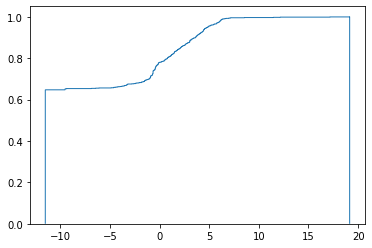

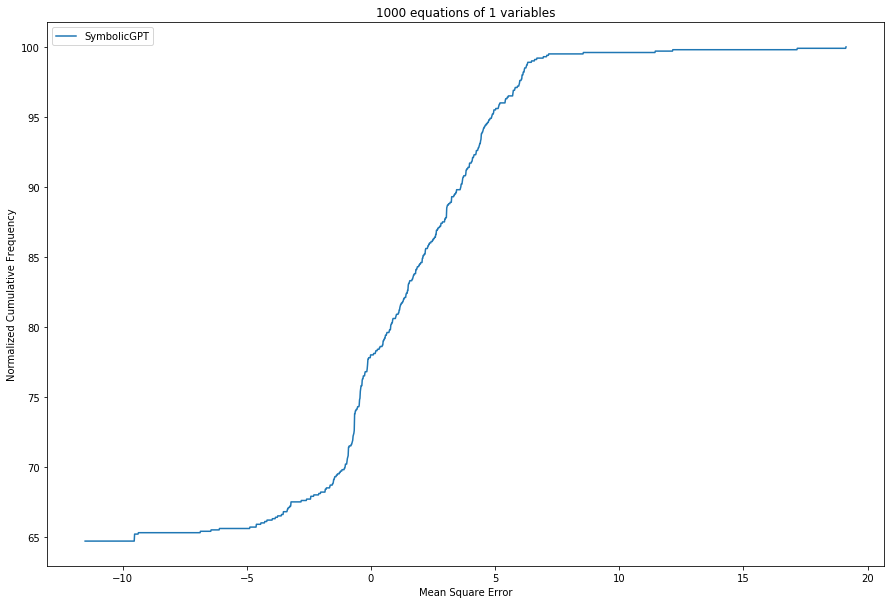

In [157]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(resultDict[fName].keys())
lists_of_error_scores = [resultDict[fName][key] for key in models]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([x+eps for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density="true")
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, model in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=model)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format('results')
plt.savefig(name)